### Default of Kaggle 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pytorch-challange-flower-dataset/sample_submission.csv
/kaggle/input/pytorch-challange-flower-dataset/README.md
/kaggle/input/pytorch-challange-flower-dataset/cat_to_name.json
/kaggle/input/pytorch-challange-flower-dataset/dataset/valid/7/image_07216.jpg
/kaggle/input/pytorch-challange-flower-dataset/dataset/valid/47/image_04957.jpg
/kaggle/input/pytorch-challange-flower-dataset/dataset/valid/47/image_04989.jpg
/kaggle/input/pytorch-challange-flower-dataset/dataset/valid/47/image_05007.jpg
/kaggle/input/pytorch-challange-flower-dataset/dataset/valid/17/image_03876.jpg
/kaggle/input/pytorch-challange-flower-dataset/dataset/valid/17/image_03829.jpg
/kaggle/input/pytorch-challange-flower-dataset/dataset/valid/17/image_03908.jpg
/kaggle/input/pytorch-challange-flower-dataset/dataset/valid/17/image_03843.jpg
/kaggle/input/pytorch-challange-flower-dataset/dataset/valid/17/image_03883.jpg
/kaggle/input/pytorch-challange-flower-dataset/dataset/valid/17/image_03831.jpg
/kaggle/inp

# Computer Vision Problem Statement 

Computer Vision (CV) Challenge: Use a pre-trained ResNet 50 and train on the Flowers dataset.

## Importing libraries

In [2]:
import torch

cuda_is_available = torch.cuda.is_available()

if cuda_is_available:
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [3]:
from IPython.display import HTML, display #we are using this for better representation during learning and inference. 

In [4]:
import numpy as np
import pandas as pd
import time
import os
import warnings
warnings.filterwarnings('ignore')
import cv2
import random
from collections import Counter
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import PIL
from PIL import Image

from torch import optim
import torchvision.models as models
import torch.nn.functional as F
from torchvision import datasets, transforms, models, utils
from torch import nn

from torchvision import datasets, transforms, models, utils
from torch.utils.data.sampler import SubsetRandomSampler

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Defining data directories and helper function for accessibility

### Key note: 
We can't use data_dir+'test' as given by the kaggle dataset as our test set, because we don't know the correct labels to this set, so we have no method to calculate accuracy. 

In [5]:
data_dir = '/kaggle/input/pytorch-challange-flower-dataset/dataset/'

train_dir = data_dir + 'train' # this contains 102 folders with each having images of a class -> we will use this for training. 
test_dir = data_dir + 'valid' # this contains 102 folders with each having images of a class -> we will use this for final testing. 

In [6]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """
    ImageFolderWithPaths is a custom dataset class that inherits from ImageFolder. 
    It overrides the __getitem__ method, which is called by the data loader when loading data. 
    This method returns a tuple containing the original image data and the file path of the image.
    """
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

## Pre-training plots for visualization

In [7]:
def get_image_distribution(dir_path):
    folder_names = []
    image_counts = []

    for folder in os.listdir(dir_path):
        folder_path = os.path.join(dir_path, folder)
        if os.path.isdir(folder_path):
            folder_names.append(folder)
            image_counts.append(len(os.listdir(folder_path)))

    # Create a DataFrame
    df = pd.DataFrame({'Folder Name': folder_names, 'Image Count': image_counts})
    return df

In [8]:
train_df = get_image_distribution(train_dir)
test_df = get_image_distribution(test_dir)

test_images=np.sum(test_df["Image Count"])
train_images = np.sum(train_df["Image Count"])

print(f"The number of test images are {train_images} ")
print(f"The number of test images are {test_images} ")

split_ratio = (train_images / (train_images + test_images)) * 100
test_ratio = (test_images / (train_images + test_images)) * 100

print(f"\nThe train to test split is {round(split_ratio, 2)} to {round(test_ratio, 2)}")

The number of test images are 6552 
The number of test images are 818 

The train to test split is 88.9 to 11.1


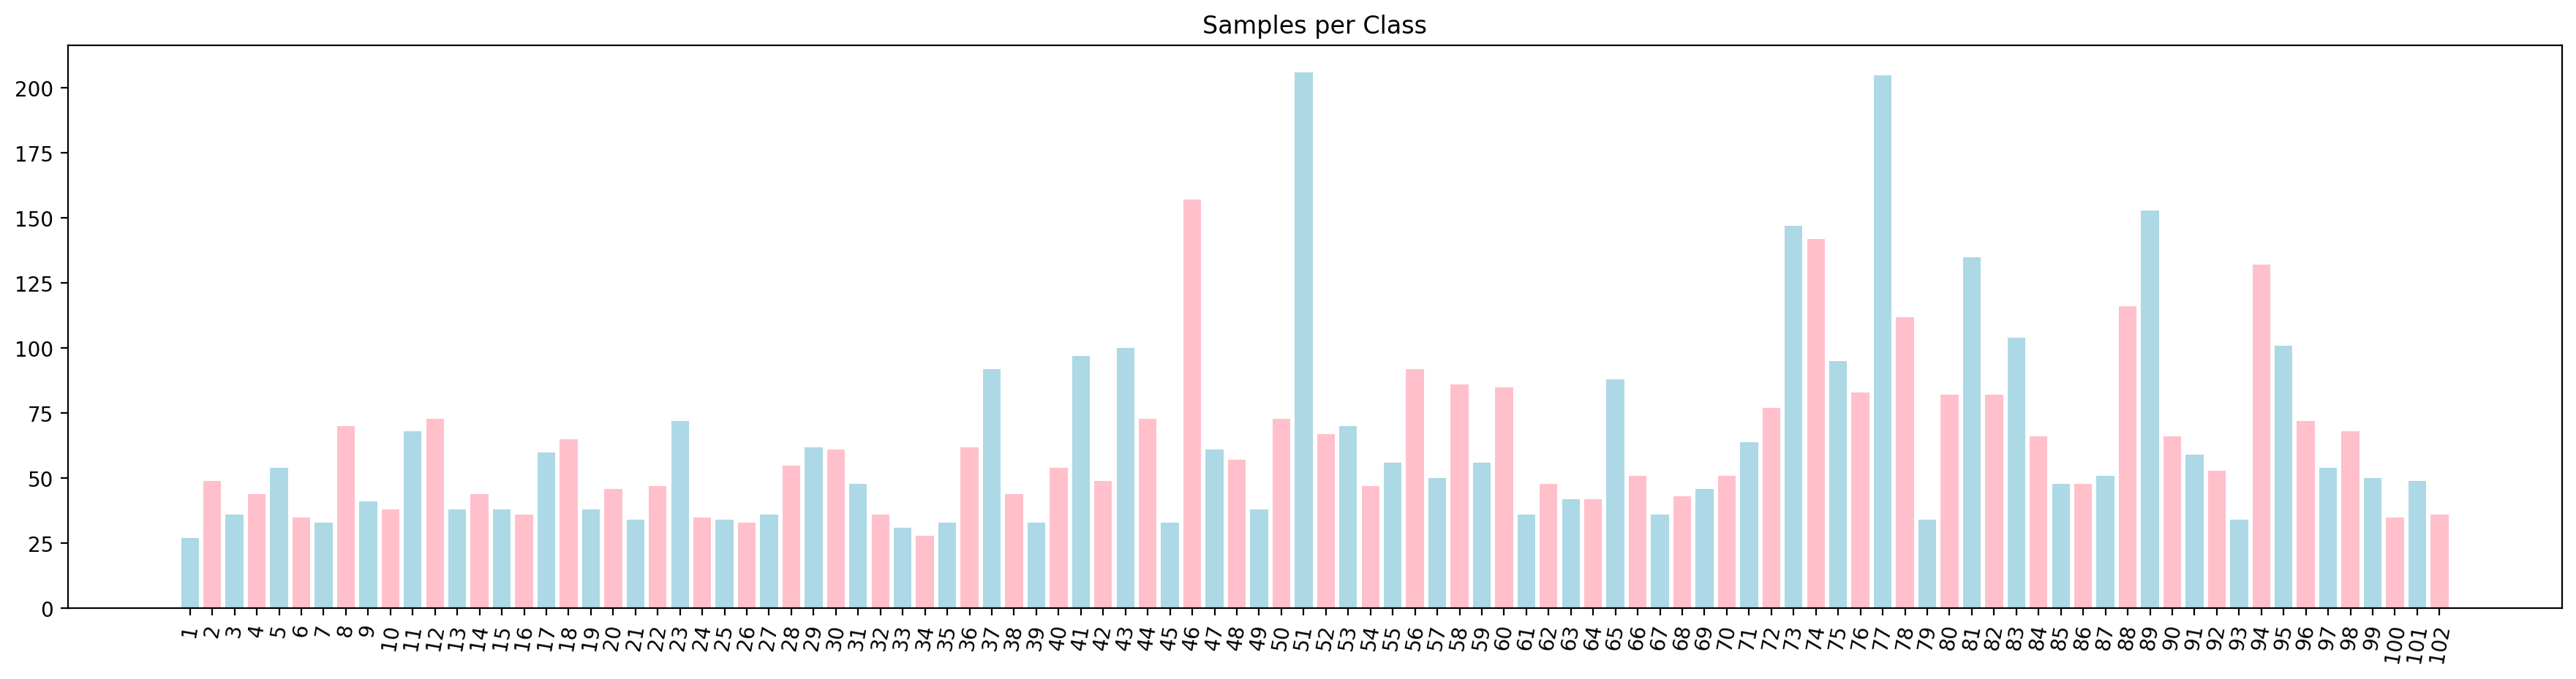

In [9]:
class_sample_counts = {}

for c in range(1, 103):
    l = class_sample_counts.get(c, 0)
    class_sample_counts[c] = l + len(os.listdir(train_dir + '/' + str(c)))

plt.figure(figsize=(22, 5))    
plt.bar(range(len(class_sample_counts)), list(class_sample_counts.values()), align='center', color=['lightblue' if i % 2 == 0 else 'pink' for i in range(len(class_sample_counts))])
plt.xticks(range(len(class_sample_counts)), list(class_sample_counts.keys()))
plt.xticks(rotation=80)
plt.title('Samples per Class')
plt.show()

## Ensuring reproducibility of results for model (Worker intervention in batch-formation)

In [10]:
import random

'''
Fixes random seeds for Python, NumPy, and PyTorch to ensure reproducible results across runs, 
enforces deterministic CUDA behavior for consistent performance, and sets unique random seeds 
for each worker in the data loader.
'''

seed_number = 2

random.seed(seed_number + 5) #fixing python notebook's seed 
np.random.seed(seed_number + 6) #fixing numpy seed 
torch.manual_seed(seed_number + 7) #fixing pytorch seed 

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#this function is used ahead
def _init_fn(worker_id):
    np.random.seed(seed_number + worker_id*2 + 5)
    random.seed(seed_number + worker_id*2 + 5)

## Image Pre-processing

In [11]:
'''

Defines batch size and data augmentation/transforms for training and validation datasets, loads the image datasets using ImageFolderWithPaths 
with specified transformations, and creates data loaders with shuffling, batching, and multi-worker support for efficient data loading.

'''

batch_size = 32 #samples of one iteration

data_transforms = {'train': transforms.Compose([transforms.Resize(256, interpolation=PIL.Image.BICUBIC),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                               ]),
                   'test': transforms.Compose([transforms.Resize(256, interpolation=PIL.Image.BICUBIC),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                               ])}
                   
image_datasets = {'train': ImageFolderWithPaths(train_dir, transform=data_transforms['train']),
                  'test': ImageFolderWithPaths(test_dir, transform=data_transforms['test'])}

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=5, worker_init_fn=_init_fn),
               'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True, num_workers=5, worker_init_fn=_init_fn)}

In [12]:
#example
image_datasets["train"]

Dataset ImageFolderWithPaths
    Number of datapoints: 6552
    Root location: /kaggle/input/pytorch-challange-flower-dataset/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

## What is Resnet 50? 

![image Resnet50 architecture](https://miro.medium.com/v2/resize:fit:1400/0*tH9evuOFqk8F41FG.png)

## Model development 
### Helpers

In [13]:
def progress_bar(value, max=100):
    return HTML("""
            {value}   
    """.format(value=value, max=max))

train_losses= []

In [14]:
class FFClassifier(nn.Module):
    #A simple feedforward neural network for classification with a single fully connected layer.
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, out_features)  # Fully connected layer.

    def forward(self, x):
        x = self.fc1(x)  # Forward pass through the layer.
        return F.log_softmax(x, dim=1)  # Apply log softmax for multi-class classification output.

      
def save_checkpoint(checkpoint_path, model):
    # Saves the model's state (class-to-index mapping, state dictionary) to a specified file for later use.
    checkpoint = {
        "class_to_idx": model.class_to_idx,
        "idx_to_class": model.idx_to_class,
        "state_dict": model.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)  # Save the checkpoint at the provided path.

## Model Creation

In [15]:
#Load the ResNet50 model without pretrained weights
model = models.resnet50(pretrained=False)

weights_path = '/kaggle/input/model_resnet50/pytorch/default/1/resnet50-0676ba61.pth'

state_dict = torch.load(weights_path)

model.load_state_dict(state_dict)

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
#The last convolutional layer of ResNet50 outputs a 2048-dimensional feature vector after global average pooling (GAP).
model.fc = FFClassifier(2048, 102)

## Defining loss function and optimizer

In [17]:
if cuda_is_available:
    model.cuda()
    
#Loss = cross entropy or negative log likelihood loss
criterion = nn.NLLLoss()

#Unfreeze all layers
for name, param in model.named_parameters():
    param.requires_grad = True

p = [
    {'params': model.conv1.parameters(), 'lr': 0.000001},
    {'params': model.layer1.parameters(), 'lr': 0.000001},
    {'params': model.layer2.parameters(), 'lr': 0.00001},
    {'params': model.layer3.parameters(), 'lr': 0.00001},
    {'params': model.layer4.parameters(), 'lr': 0.0001},
    {'params': model.fc.parameters(), 'lr': 0.001}
]

#Redefining the optimizer with the updated param groups
optimizer = optim.Adam(p, weight_decay=0.001)

### Train function 

In [18]:
def train(n_epochs=10, run_schedular=True):
    
    global train_losses

    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}")
                
        # Step the scheduler before each epoch if enabled
        if run_schedular:
            scheduler.step()

       
        # Initialize metrics for this epoch
        train_loss_sum = 0.0
        valid_loss_sum = 0.0
        train_correct_count = 0.0
        valid_correct_count = 0.0

      
        #Choose the training datasets
        train_dataloader = dataloaders['train']

        #Train the model 
        
        print("Training...")
        training_start_time = time.time()
        train_display = display(progress_bar(0, 100), display_id=False)
        model.train()
        
        num_batches = math.ceil(len(train_dataloader.dataset) / batch_size)

        for batch_idx, (images, labels, paths) in enumerate(train_dataloader):
            if cuda_is_available:
                images, labels = images.cuda(), labels.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                loss.backward()  # Backpropagation
                optimizer.step()  # Update weights

            # Accumulate loss and correct predictions
            train_loss_sum += loss.item() * images.size(0)
            _, predicted_labels = torch.max(outputs, -1)
            train_correct_count += (predicted_labels == labels).sum().item()

            #Display progress
            progress = (batch_idx + 1) * 100.0 / num_batches
            print(f"Training Progress: {progress:.2f}%", end="\r")

      

        epoch_end_time = time.time()

      
        #Calculate avg losses 
        
        train_loss = train_loss_sum / len(train_dataloader.dataset)
        train_acc = train_correct_count / len(train_dataloader.dataset)

        train_losses.append(train_loss)

        print(f'Training Loss={train_loss:.6f}  Training Accuracy={train_acc:.6f}')

        
        torch.save(model.state_dict(), 'state_dict_best_current_acc.pt')
            

        print("\n")


## Learning

In [19]:
n_epochs = 10
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
train(n_epochs, True)

Epoch 1
Training...


Training Loss=1.174955  Training Accuracy=0.752595


Epoch 2
Training...


Training Loss=0.085330  Training Accuracy=0.982295


Epoch 3
Training...


Training Loss=0.027197  Training Accuracy=0.996032


Epoch 4
Training...


Training Loss=0.012795  Training Accuracy=0.998932


Epoch 5
Training...


Training Loss=0.008843  Training Accuracy=0.999847


Epoch 6
Training...


Training Loss=0.006561  Training Accuracy=0.999847


Epoch 7
Training...


Training Loss=0.006070  Training Accuracy=1.000000


Epoch 8
Training...


Training Loss=0.005676  Training Accuracy=1.000000


Epoch 9
Training...


Training Loss=0.005523  Training Accuracy=1.000000


Epoch 10
Training...


Training Loss=0.005698  Training Accuracy=1.000000




## Post training plots

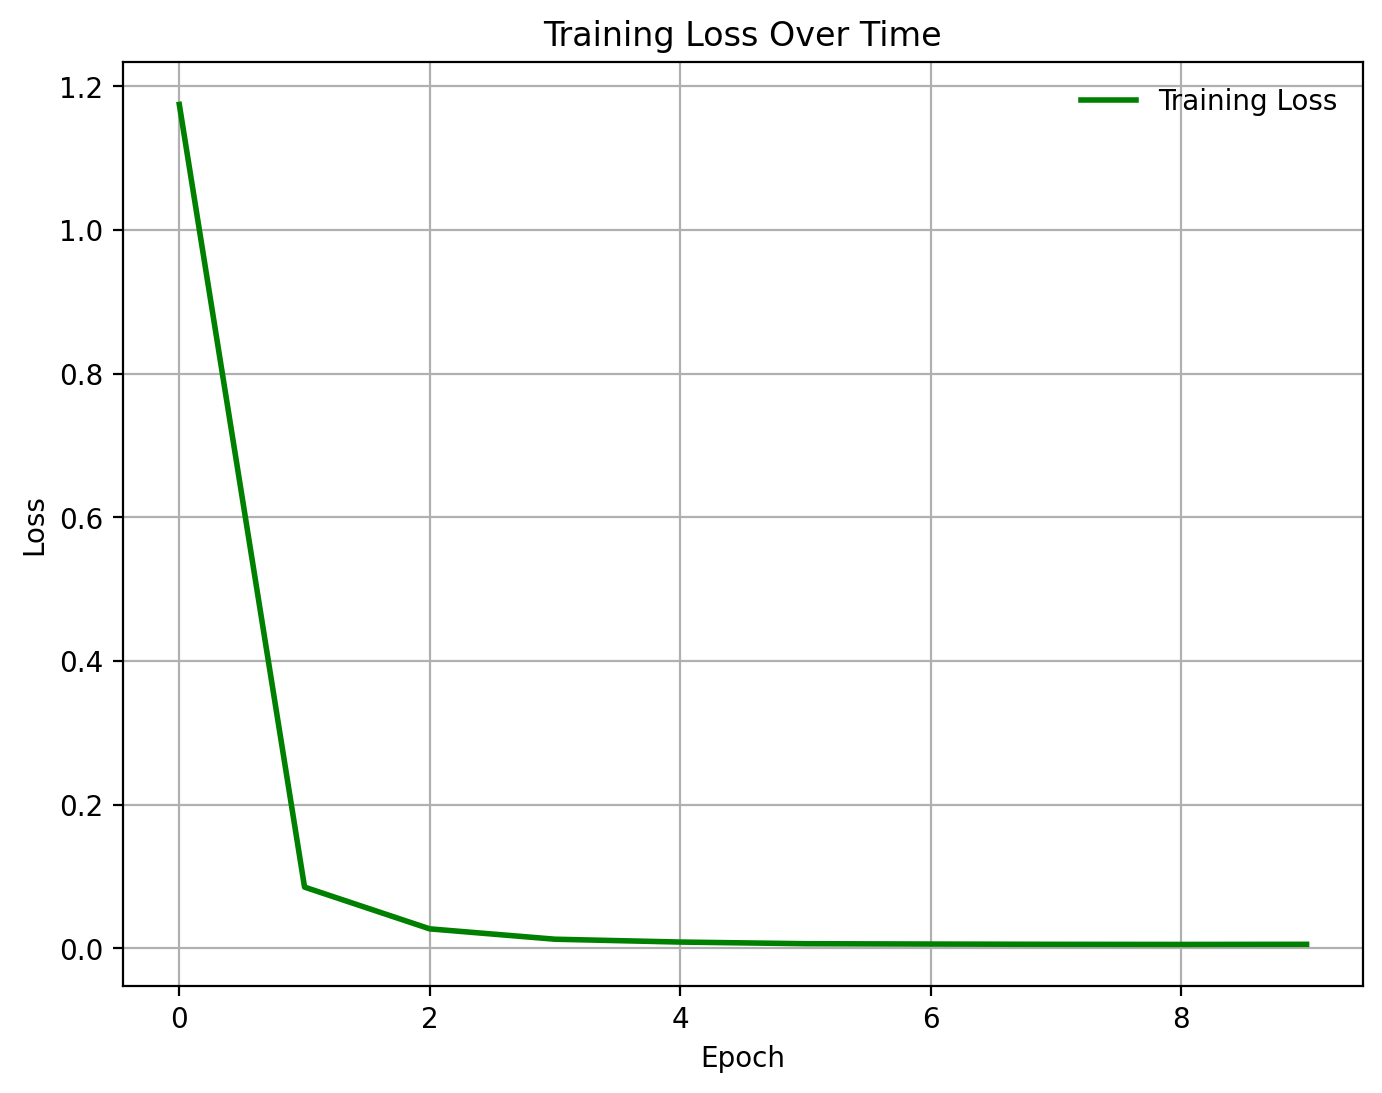

In [20]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Training Loss', color='green', linewidth=2)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(frameon=False, loc='upper right')
plt.grid(True)
plt.show()

## Saving checkpoint and testing

In [21]:
idx_to_class = {v: k for k, v in image_datasets['train'].class_to_idx.items()}

In [22]:
model.class_to_idx = image_datasets['train'].class_to_idx
model.idx_to_class = idx_to_class

save_checkpoint('model_checkpoint.pt', model)

## Saving final trained model 

In [23]:
torch.save(model.state_dict(), 'resnet50_trained_102_model_weights.pth')

## Loading Testing Model

In [24]:
model_test = models.resnet50(pretrained=False)

weights_path = '/kaggle/working/resnet50_trained_102_model_weights.pth'

model_test.fc = FFClassifier(2048, 102)

state_dict = torch.load(weights_path)

model_test.load_state_dict(state_dict)

model_test.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Final Testing

In [25]:
#Initialize variables to track total loss and correct predictions
total_test_loss = 0.0
correct_predictions_count = 0.0
wrong_count=0

testing_start_time = time.time()
print("Testing....\n")
test_progress_display = display(progress_bar(0, 100), display_id=True)

model_test.eval()   

if cuda_is_available:
    model_test.cuda()

num_batches = math.ceil(len(dataloaders['test'].dataset) / batch_size)

for batch_index, (batch_images, batch_labels, image_paths) in enumerate(dataloaders['test']):
    if cuda_is_available:
        batch_images, batch_labels = batch_images.cuda(), batch_labels.cuda()

    with torch.set_grad_enabled(False):
        output_predictions = model_test(batch_images)  # Output shape: (batch_size x 102)
        loss = criterion(output_predictions, batch_labels)  # Calculate loss

    total_test_loss += loss.item() * batch_images.size(0)

    _, predicted_labels = torch.max(output_predictions, -1)
    correct_predictions_count += (predicted_labels == batch_labels).double().sum().item()
    
    
    for index in range(len(batch_labels.data)):
        if batch_labels[index] != predicted_labels[index]:
            wrong_count+=1
            print(f"Wrongly classified image: {image_paths[index]}")
            print(f"    Truth: {idx_to_class[batch_labels[index].item()]}, Predicted: {idx_to_class[predicted_labels[index].item()]}")

    progress = (batch_index + 1) * 100.0 / num_batches
    test_progress_display.update(progress_bar(progress, 100))

testing_end_time = time.time()

#Calculate average losses and accuracy 

average_test_loss = total_test_loss / len(dataloaders['test'].dataset)
average_test_accuracy = correct_predictions_count / len(dataloaders['test'].dataset)

print(f"\nThe number of wrongly predicted output is {wrong_count} out of the test set of size {test_images}\n")
print('\n\nTesting Loss={:.6f}  Testing Accuracy={:.6f}  Duration={:.2f}'.format(
    average_test_loss, 
    average_test_accuracy, 
    testing_end_time - testing_start_time
))


Testing....



Wrongly classified image: /kaggle/input/pytorch-challange-flower-dataset/dataset/valid/51/image_03927.jpg
    Truth: 51, Predicted: 9
Wrongly classified image: /kaggle/input/pytorch-challange-flower-dataset/dataset/valid/36/image_04333.jpg
    Truth: 36, Predicted: 85
Wrongly classified image: /kaggle/input/pytorch-challange-flower-dataset/dataset/valid/30/image_03485.jpg
    Truth: 30, Predicted: 32
Wrongly classified image: /kaggle/input/pytorch-challange-flower-dataset/dataset/valid/4/image_05677.jpg
    Truth: 4, Predicted: 88
Wrongly classified image: /kaggle/input/pytorch-challange-flower-dataset/dataset/valid/99/image_07869.jpg
    Truth: 99, Predicted: 8
Wrongly classified image: /kaggle/input/pytorch-challange-flower-dataset/dataset/valid/20/image_04927.jpg
    Truth: 20, Predicted: 75
Wrongly classified image: /kaggle/input/pytorch-challange-flower-dataset/dataset/valid/53/image_03693.jpg
    Truth: 53, Predicted: 32
Wrongly classified image: /kaggle/input/pytorch-challange-f

## Potential Improvements and acknowledgment

- Using a validation set. And then re-training on the train+validation dataset. We can also try startegies like K-fold cross validation and then use ensemble learning.
- At times, train+validation (as validation provided = testing in our case) is of the same distribution, so you are expected to get a good result. 

I would like to thank Andrew Ng for his course Deep Learning Specialization for instilling strong fundamentals in me. 